In [1]:
# 1.1 导入必要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error, mean_absolute_error
import hnswlib
import warnings

warnings.filterwarnings("ignore")

# 设置中文显示和图形样式
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False
# sns.set_style("whitegrid")


In [3]:
# 1.2 加载数据
# 这里以MovieLens数据集为例，你需要根据实际数据调整
# 假设数据文件为ratings.csv，包含列：userId, movieId, rating, timestamp

# 如果使用MovieLens数据集，可以从这里下载：https://grouplens.org/datasets/movielens/
# 这里我们创建一个模拟数据集用于演示


def read_data():
    ratings = pd.read_csv(
        "../datasets/ml-1m/ratings.dat",
        sep="::",
        names=["userId", "movieId", "rating", "timestamp"],
    )
    movies = pd.read_csv(
        "../datasets/ml-1m/movies.dat",
        sep="::",
        names=["movieId", "title", "genres"],
    )
    df = pd.merge(ratings, movies[['movieId', 'title']], on='movieId')


    # 去重
    df = df.drop_duplicates(["userId", "movieId"])

    return df


df = read_data()
print(f"数据形状: {df.shape}")
print(f"用户数: {df['userId'].nunique()}")
print(f"电影数: {df['movieId'].nunique()}")
print(f"评分密度: {df.shape[0] / (df['userId'].nunique() * df['movieId'].nunique()):.4f}")

数据形状: (1000209, 5)
用户数: 6040
电影数: 3706
评分密度: 0.0447


数据前5行:
   userId  movieId  rating  timestamp                                   title
0       1     1193       5  978300760  One Flew Over the Cuckoo's Nest (1975)
1       1      661       3  978302109        James and the Giant Peach (1996)
2       1      914       3  978301968                     My Fair Lady (1964)
3       1     3408       4  978300275                  Erin Brockovich (2000)
4       1     2355       5  978824291                    Bug's Life, A (1998)

数据信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   userId     1000209 non-null  int64 
 1   movieId    1000209 non-null  int64 
 2   rating     1000209 non-null  int64 
 3   timestamp  1000209 non-null  int64 
 4   title      1000209 non-null  object
dtypes: int64(4), object(1)
memory usage: 38.2+ MB
None

数据统计描述:
             userId       movieId        rating     ti

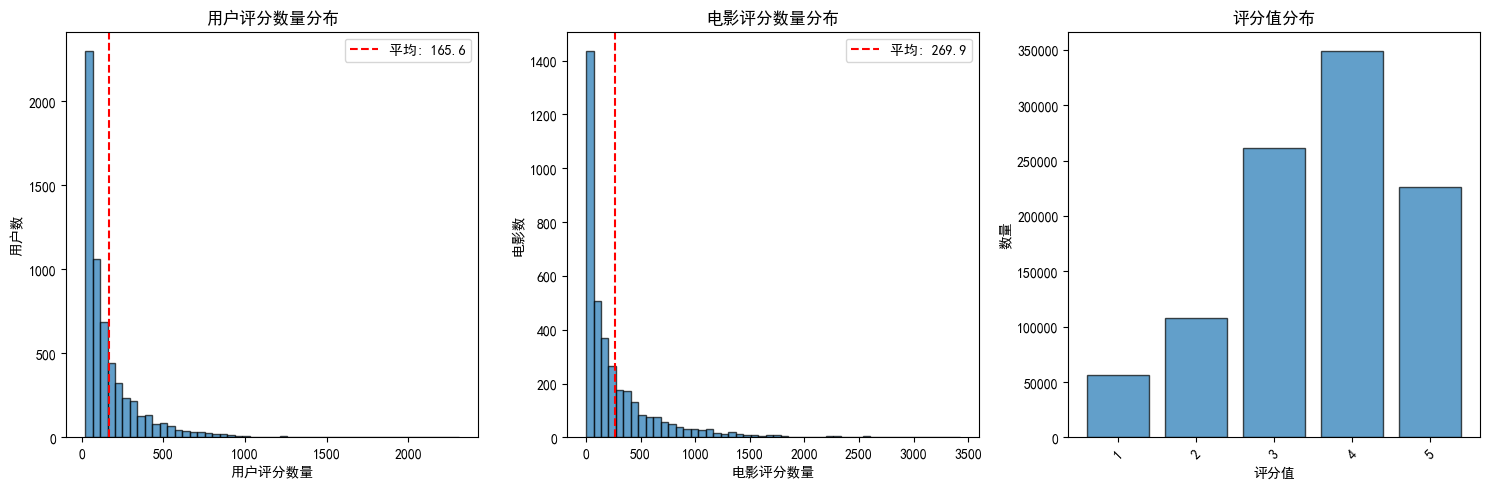


最热门的10部电影:
movieId
2858    3428
260     2991
1196    2990
1210    2883
480     2672
2028    2653
589     2649
2571    2590
1270    2583
593     2578
Name: count, dtype: int64

最活跃的10位用户:
userId
4169    2314
1680    1850
4277    1743
1941    1595
1181    1521
889     1518
3618    1344
2063    1323
1150    1302
1015    1286
Name: count, dtype: int64

原始数据: 1000209 条评分
清洗后数据: 999611 条评分
剩余用户数: 6040
剩余电影数: 3416


In [4]:
# 2.1 查看数据基本信息
print("数据前5行:")
print(df.head())
print("\n数据信息:")
print(df.info())
print("\n数据统计描述:")
print(df.describe())

# 2.2 用户评分分布
plt.figure(figsize=(15, 5))

# 用户评分数量分布
plt.subplot(1, 3, 1)
user_rating_counts = df["userId"].value_counts()
plt.hist(user_rating_counts, bins=50, edgecolor="black", alpha=0.7)
plt.xlabel("用户评分数量")
plt.ylabel("用户数")
plt.title("用户评分数量分布")
plt.axvline(user_rating_counts.mean(), color="red", linestyle="--", label=f"平均: {user_rating_counts.mean():.1f}")
plt.legend()

# 电影评分数量分布
plt.subplot(1, 3, 2)
movie_rating_counts = df["movieId"].value_counts()
plt.hist(movie_rating_counts, bins=50, edgecolor="black", alpha=0.7)
plt.xlabel("电影评分数量")
plt.ylabel("电影数")
plt.title("电影评分数量分布")
plt.axvline(movie_rating_counts.mean(), color="red", linestyle="--", label=f"平均: {movie_rating_counts.mean():.1f}")
plt.legend()

# 评分值分布
plt.subplot(1, 3, 3)
rating_values = df["rating"].value_counts().sort_index()
plt.bar(rating_values.index, rating_values.values, edgecolor="black", alpha=0.7)
plt.xlabel("评分值")
plt.ylabel("数量")
plt.title("评分值分布")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 2.3 热门电影和活跃用户
print("\n最热门的10部电影:")
top_movies = df["movieId"].value_counts().head(10)
print(top_movies)

print("\n最活跃的10位用户:")
top_users = df["userId"].value_counts().head(10)
print(top_users)

# 2.4 数据清洗
# 移除评分数量过少的用户和电影（可选）
MIN_USER_RATINGS = 5
MIN_MOVIE_RATINGS = 5

print(f"\n原始数据: {len(df)} 条评分")

# 移除评分过少的用户
user_counts = df["userId"].value_counts()
valid_users = user_counts[user_counts >= MIN_USER_RATINGS].index
df = df[df["userId"].isin(valid_users)]

# 移除评分过少的电影
movie_counts = df["movieId"].value_counts()
valid_movies = movie_counts[movie_counts >= MIN_MOVIE_RATINGS].index
df = df[df["movieId"].isin(valid_movies)]

print(f"清洗后数据: {len(df)} 条评分")
print(f"剩余用户数: {df['userId'].nunique()}")
print(f"剩余电影数: {df['movieId'].nunique()}")


划分数据集...
训练集大小: 802085 (80.2%)
测试集大小: 197526 (19.8%)
训练集用户数: 6040
测试集用户数: 6040

训练集和测试集重叠用户数: 6040


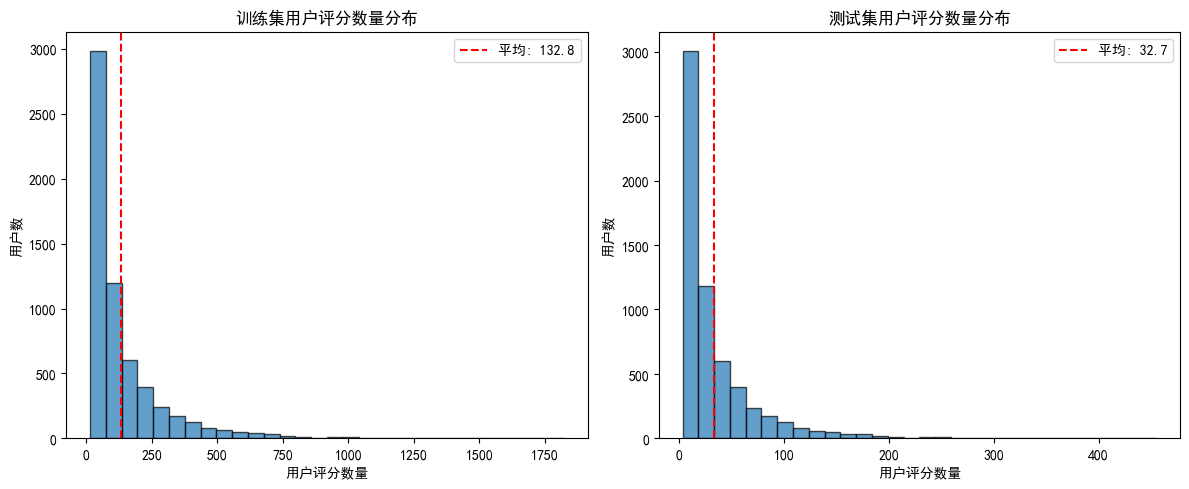

In [5]:
# 3.1 实现基于用户的留出法
def split_low_memory(df, test_ratio=0.2, min_items=5, seed=42):
    """
    基于用户的留出法划分数据集

    参数:
    - df: 包含userId, movieId, rating的DataFrame
    - test_ratio: 测试集比例
    - min_items: 用户最少评分数量（低于此值的用户不参与划分）
    - seed: 随机种子

    返回:
    - train_df: 训练集
    - test_df: 测试集
    """
    # 为了可重复性
    rng = np.random.default_rng(seed=seed)

    test_indices = []

    # 按用户分组，收集测试集索引
    for user, group in df.groupby("userId"):
        if len(group) < min_items:
            # 评分太少的用户，全部放入训练集
            continue

        test_size = max(1, int(len(group) * test_ratio))
        idx = rng.choice(group.index, size=test_size, replace=False)
        test_indices.extend(idx)

    test_indices = set(test_indices)

    # 一次性划分
    mask = df.index.isin(test_indices)
    test_df = df[mask].copy()
    train_df = df[~mask].copy()

    return train_df, test_df


# 3.2 划分数据集
print("划分数据集...")
train_df, test_df = split_low_memory(df, test_ratio=0.2, min_items=5)
print(f"训练集大小: {len(train_df)} ({len(train_df) / len(df) * 100:.1f}%)")
print(f"测试集大小: {len(test_df)} ({len(test_df) / len(df) * 100:.1f}%)")
print(f"训练集用户数: {train_df['userId'].nunique()}")
print(f"测试集用户数: {test_df['userId'].nunique()}")

# 3.3 检查划分结果
# 确保没有用户同时出现在训练集和测试集中（对于参与划分的用户）
train_users = set(train_df["userId"])
test_users = set(test_df["userId"])
overlap = train_users.intersection(test_users)
print(f"\n训练集和测试集重叠用户数: {len(overlap)}")

# 检查用户评分数量分布
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
train_user_counts = train_df["userId"].value_counts()
plt.hist(train_user_counts, bins=30, edgecolor="black", alpha=0.7)
plt.xlabel("用户评分数量")
plt.ylabel("用户数")
plt.title("训练集用户评分数量分布")
plt.axvline(train_user_counts.mean(), color="red", linestyle="--", label=f"平均: {train_user_counts.mean():.1f}")
plt.legend()

plt.subplot(1, 2, 2)
test_user_counts = test_df["userId"].value_counts()
plt.hist(test_user_counts, bins=30, edgecolor="black", alpha=0.7)
plt.xlabel("用户评分数量")
plt.ylabel("用户数")
plt.title("测试集用户评分数量分布")
plt.axvline(test_user_counts.mean(), color="red", linestyle="--", label=f"平均: {test_user_counts.mean():.1f}")
plt.legend()

plt.tight_layout()
plt.show()


创建稀疏矩阵...
训练集稀疏矩阵形状: (6040, 3416)
训练集非零元素数量: 802085
训练集密度: 0.038875

测试集稀疏矩阵形状: (6040, 3416)
测试集非零元素数量: 197526
测试集密度: 0.009573


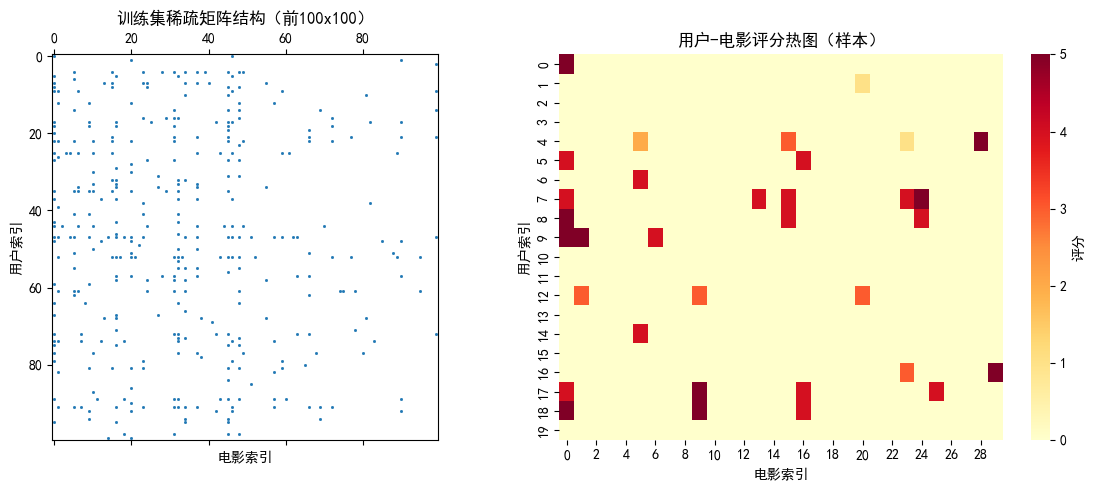

In [6]:
# 4.1 创建稀疏矩阵函数
def create_sparse_matrix(train_df, test_df):
    """
    创建训练集和测试集的稀疏矩阵

    参数:
    - train_df: 训练集DataFrame
    - test_df: 测试集DataFrame

    返回:
    - train_sparse: 训练集稀疏矩阵
    - test_sparse: 测试集稀疏矩阵
    """
    # Step 1: 只在训练集上定义类别映射
    user_cat = train_df["userId"].astype("category")
    movie_cat = train_df["movieId"].astype("category")

    train_user_codes = user_cat.cat.codes
    train_movie_codes = movie_cat.cat.codes

    # Step 2: 获取训练集的类别列表
    user_categories = user_cat.cat.categories
    movie_categories = movie_cat.cat.categories

    # Step 3: 测试集使用训练集的映射
    test_user_codes = pd.Categorical(test_df["userId"], categories=user_categories).codes
    test_movie_codes = pd.Categorical(test_df["movieId"], categories=movie_categories).codes

    # Step 4: 过滤测试集中未出现在训练集的用户/电影
    mask = (test_user_codes != -1) & (test_movie_codes != -1)

    test_user_codes = test_user_codes[mask]
    test_movie_codes = test_movie_codes[mask]
    test_ratings = test_df["rating"].values[mask]

    # Step 5: 创建稀疏矩阵
    train_sparse = csr_matrix((train_df["rating"], (train_user_codes, train_movie_codes)))

    # 使用相同的形状
    test_sparse = csr_matrix((test_ratings, (test_user_codes, test_movie_codes)), shape=train_sparse.shape)

    return train_sparse, test_sparse


# 4.2 创建稀疏矩阵
print("创建稀疏矩阵...")
train_sparse, test_sparse = create_sparse_matrix(train_df, test_df)

print(f"训练集稀疏矩阵形状: {train_sparse.shape}")
print(f"训练集非零元素数量: {train_sparse.nnz}")
print(f"训练集密度: {train_sparse.nnz / (train_sparse.shape[0] * train_sparse.shape[1]):.6f}")

print(f"\n测试集稀疏矩阵形状: {test_sparse.shape}")
print(f"测试集非零元素数量: {test_sparse.nnz}")
print(f"测试集密度: {test_sparse.nnz / (test_sparse.shape[0] * test_sparse.shape[1]):.6f}")

# 4.3 可视化稀疏矩阵结构
plt.figure(figsize=(12, 5))

# 稀疏矩阵结构
plt.subplot(1, 2, 1)
# 只显示前100x100的部分，否则太大
small_train = train_sparse[:100, :100].toarray()
plt.spy(small_train, markersize=1)
plt.title("训练集稀疏矩阵结构（前100x100）")
plt.xlabel("电影索引")
plt.ylabel("用户索引")

# 用户-电影评分热图
plt.subplot(1, 2, 2)
# 选择前20个用户和前30部电影
sample_data = train_sparse[:20, :30].toarray()
sns.heatmap(sample_data, cmap="YlOrRd", cbar_kws={"label": "评分"})
plt.title("用户-电影评分热图（样本）")
plt.xlabel("电影索引")
plt.ylabel("用户索引")

plt.tight_layout()
plt.show()


执行SVD降维...
使用SVD将用户特征从 3416 维降到 64 维...
SVD解释的方差比例: 0.3645

构建HNSW索引...


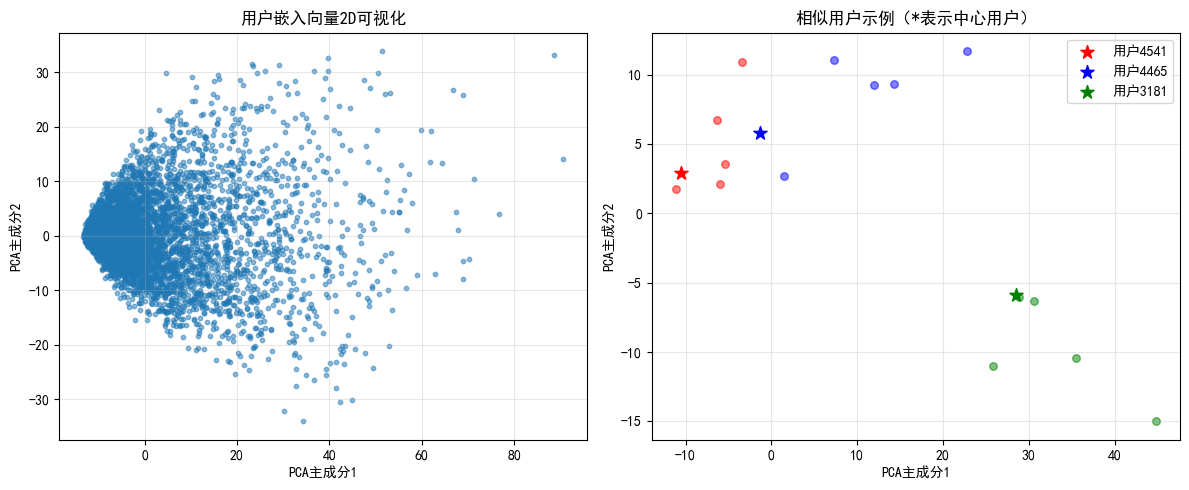

In [7]:
# 5.1 SVD降维函数
def svd_dimension_reduction(train_sparse, dim=128):
    """
    使用SVD对用户特征进行降维

    参数:
    - train_sparse: 训练集稀疏矩阵
    - dim: 降维后的维度

    返回:
    - user_embeddings: 用户嵌入向量
    - svd_model: 训练好的SVD模型
    """
    print(f"使用SVD将用户特征从 {train_sparse.shape[1]} 维降到 {dim} 维...")

    svd = TruncatedSVD(n_components=dim, random_state=42)
    user_embeddings = svd.fit_transform(train_sparse).astype("float32")

    # 计算方差解释率
    explained_variance = svd.explained_variance_ratio_.sum()
    print(f"SVD解释的方差比例: {explained_variance:.4f}")

    return user_embeddings, svd


# 5.2 构建HNSW索引
def build_hnsw_index(user_embeddings, ef_construction=200, M=32, ef_search=128):
    """
    构建HNSW索引用于快速相似用户查找

    参数:
    - user_embeddings: 用户嵌入向量
    - ef_construction: 构建时的参数
    - M: 每个节点的连接数
    - ef_search: 搜索时的参数

    返回:
    - index: HNSW索引对象
    """
    n_users, dim = user_embeddings.shape

    # 归一化向量（用于余弦相似度）
    user_embeddings_norm = normalize(user_embeddings, axis=1).astype("float32")

    # 创建索引
    index = hnswlib.Index(space="cosine", dim=dim)
    index.init_index(max_elements=n_users, ef_construction=ef_construction, M=M)
    index.add_items(user_embeddings_norm)
    index.set_ef(ef_search)

    return index, user_embeddings_norm


# 5.3 执行SVD降维
print("执行SVD降维...")
dim = 64  # 降维后的维度
user_embeddings, svd_model = svd_dimension_reduction(train_sparse, dim=dim)

# 5.4 构建HNSW索引
print("\n构建HNSW索引...")
index, user_embeddings_norm = build_hnsw_index(user_embeddings)

# 5.5 可视化降维效果
# 使用PCA将降维后的向量进一步降到2维进行可视化
from sklearn.decomposition import PCA

# 将用户嵌入降到2维进行可视化
pca = PCA(n_components=2)
user_2d = pca.fit_transform(user_embeddings)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(user_2d[:, 0], user_2d[:, 1], alpha=0.5, s=10)
plt.xlabel("PCA主成分1")
plt.ylabel("PCA主成分2")
plt.title("用户嵌入向量2D可视化")
plt.grid(True, alpha=0.3)

# 随机选择几个用户，查看他们的相似用户
plt.subplot(1, 2, 2)
sample_users = np.random.choice(user_embeddings.shape[0], 3, replace=False)
colors = ["red", "blue", "green"]

for i, user_id in enumerate(sample_users):
    # 查找相似用户
    similar_ids, distances = index.knn_query(user_embeddings_norm[user_id : user_id + 1], k=6)
    similar_ids = similar_ids[0][1:]  # 排除自己
    distances = distances[0][1:]

    # 绘制中心用户
    plt.scatter(user_2d[user_id, 0], user_2d[user_id, 1], color=colors[i], s=100, marker="*", label=f"用户{user_id}")

    # 绘制相似用户
    plt.scatter(user_2d[similar_ids, 0], user_2d[similar_ids, 1], color=colors[i], alpha=0.5, s=30)

plt.xlabel("PCA主成分1")
plt.ylabel("PCA主成分2")
plt.title("相似用户示例（*表示中心用户）")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [8]:
# 6.1 用户协同过滤模型类
class UserBasedCF:
    """用户协同过滤模型"""

    def __init__(self, k=50, dim=64, ef_construction=200, M=32, ef_search=128):
        """
        初始化模型

        参数:
        - k: 最近邻数量
        - dim: SVD降维维度
        - ef_construction: HNSW构建参数
        - M: HNSW连接数
        - ef_search: HNSW搜索参数
        """
        self.k = k
        self.dim = dim
        self.ef_construction = ef_construction
        self.M = M
        self.ef_search = ef_search

        self.svd = None
        self.index = None
        self.user_embeddings_norm = None
        self.train_sparse = None
        self.user_means = None

    def fit(self, train_sparse):
        """
        训练模型

        参数:
        - train_sparse: 训练集稀疏矩阵
        """
        print("训练用户协同过滤模型...")
        self.train_sparse = train_sparse

        # 1. 计算用户平均评分（用于冷启动处理）
        self.user_means = np.array(train_sparse.mean(axis=1)).flatten()
        global_mean = np.mean(self.user_means)

        # 2. SVD降维
        self.svd = TruncatedSVD(n_components=self.dim, random_state=42)
        user_embeddings = self.svd.fit_transform(train_sparse).astype("float32")

        # 3. 归一化
        self.user_embeddings_norm = normalize(user_embeddings, axis=1).astype("float32")

        # 4. 构建HNSW索引
        n_users = self.user_embeddings_norm.shape[0]
        self.index = hnswlib.Index(space="cosine", dim=self.dim)
        self.index.init_index(max_elements=n_users, ef_construction=self.ef_construction, M=self.M)
        self.index.add_items(self.user_embeddings_norm)
        self.index.set_ef(self.ef_search)

        print(f"模型训练完成！")
        print(f"用户数量: {n_users}")
        print(f"降维维度: {self.dim}")
        print(f"最近邻数量: {self.k}")

        return self

    def predict_for_user(self, user_id, item_ids=None, return_similarities=False):
        """
        为用户预测评分

        参数:
        - user_id: 用户ID（稀疏矩阵中的索引）
        - item_ids: 要预测的物品ID列表，None表示预测所有物品
        - return_similarities: 是否返回相似用户信息

        返回:
        - predictions: 预测评分
        - 如果return_similarities=True，同时返回相似用户信息
        """
        if self.index is None:
            raise ValueError("模型未训练，请先调用fit()方法")

        # 如果未指定item_ids，预测所有物品
        if item_ids is None:
            n_items = self.train_sparse.shape[1]
            item_ids = np.arange(n_items)

        # 1. 查找相似用户
        similar_users, distances = self.index.knn_query(
            self.user_embeddings_norm[user_id : user_id + 1],
            k=self.k + 1,  # +1是因为包含自己
        )

        # 获取相似用户（排除自己）
        similar_users = similar_users[0][1:]  # 第一个是自己
        similarities = 1 - distances[0][1:]  # 余弦距离转相似度

        # 2. 获取相似用户的评分矩阵
        similar_ratings = self.train_sparse[similar_users, :]

        # 3. 计算加权平均预测
        predictions = []
        valid_counts = []

        for item_id in item_ids:
            # 获取相似用户对该物品的评分
            item_ratings = similar_ratings[:, item_id].toarray().flatten()

            # 找出有评分的相似用户
            valid_mask = item_ratings > 0
            valid_similarities = similarities[valid_mask]
            valid_ratings = item_ratings[valid_mask]

            if len(valid_ratings) > 0 and np.sum(valid_similarities) > 0:
                # 加权平均
                pred = np.dot(valid_similarities, valid_ratings) / np.sum(valid_similarities)
                predictions.append(pred)
                valid_counts.append(len(valid_ratings))
            else:
                # 冷启动处理：使用用户平均评分或全局平均
                if self.user_means[user_id] > 0:
                    predictions.append(self.user_means[user_id])
                else:
                    predictions.append(np.mean(self.user_means[self.user_means > 0]))
                valid_counts.append(0)

        predictions = np.array(predictions)

        if return_similarities:
            return predictions, similar_users, similarities, np.array(valid_counts)
        else:
            return predictions

    def predict(self, user_ids, item_ids):
        """
        批量预测评分

        参数:
        - user_ids: 用户ID列表（稀疏矩阵中的索引）
        - item_ids: 物品ID列表（与user_ids一一对应）

        返回:
        - predictions: 预测评分列表
        """
        predictions = []

        for user_id, item_id in zip(user_ids, item_ids):
            pred = self.predict_for_user(user_id, [item_id])[0]
            predictions.append(pred)

        return np.array(predictions)


# 6.2 训练模型
print("训练用户协同过滤模型...")
model = UserBasedCF(k=30, dim=64)
model.fit(train_sparse)

# 6.3 测试模型预测
# 随机选择几个用户-物品对进行预测
test_users, test_items = test_sparse.nonzero()
n_samples = min(10, len(test_users))
sample_indices = np.random.choice(len(test_users), n_samples, replace=False)

print("\n模型预测示例:")
print("-" * 60)
print(f"{'用户ID':<10} {'物品ID':<10} {'真实评分':<12} {'预测评分':<12} {'误差':<10}")
print("-" * 60)

for idx in sample_indices:
    user_id = test_users[idx]
    item_id = test_items[idx]
    true_rating = test_sparse[user_id, item_id]

    # 预测
    pred_rating = model.predict_for_user(user_id, [item_id])[0]

    error = abs(pred_rating - true_rating)

    print(f"{user_id:<10} {item_id:<10} {true_rating:<12.4f} {pred_rating:<12.4f} {error:<10.4f}")

print("-" * 60)


训练用户协同过滤模型...
训练用户协同过滤模型...
模型训练完成！
用户数量: 6040
降维维度: 64
最近邻数量: 30

模型预测示例:
------------------------------------------------------------
用户ID       物品ID       真实评分         预测评分         误差        
------------------------------------------------------------
1805       2511       4.0000       4.0033       0.0033    
5511       2963       5.0000       3.9071       1.0929    
2454       1015       5.0000       4.0610       0.9390    
1018       2814       3.0000       3.5288       0.5288    
2287       380        1.0000       2.0000       1.0000    
3948       2546       2.0000       4.1640       2.1640    
236        1253       4.0000       3.7446       0.2554    
3053       3301       2.0000       1.4036       0.5964    
5926       1517       4.0000       4.1593       0.1593    
698        1286       3.0000       2.4865       0.5135    
------------------------------------------------------------


评估模型性能...

模型评估结果:
RMSE: 1.2201
MAE: 0.9011
MSE: 1.4886
n_samples: 197526


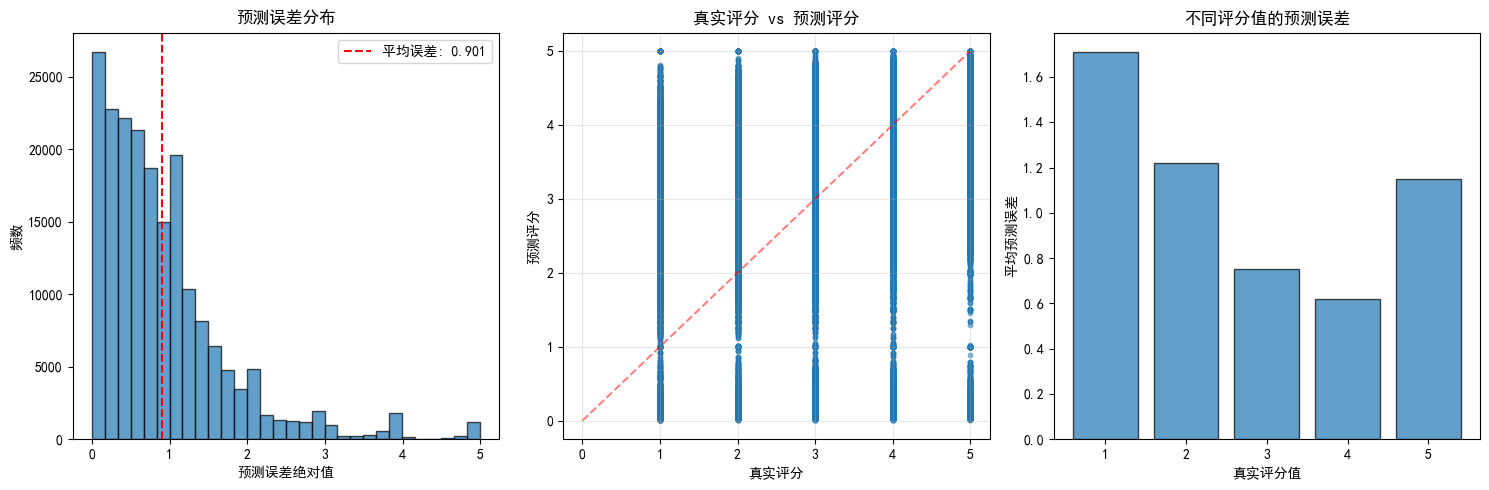


为用户生成推荐...

为用户 2826 的Top-10推荐:
----------------------------------------
用户历史评分（示例）:
  物品 205: 4.0
  物品 332: 3.0
  物品 432: 4.0
  物品 548: 4.0
  物品 782: 3.0

推荐物品:
   1. 物品 816: 预测评分 5.000
   2. 物品 1682: 预测评分 5.000
   3. 物品 2694: 预测评分 5.000
   4. 物品 3041: 预测评分 5.000
   5. 物品 954: 预测评分 5.000
   6. 物品 3026: 预测评分 5.000
   7. 物品 10: 预测评分 5.000
   8. 物品 2890: 预测评分 5.000
   9. 物品 1838: 预测评分 5.000
  10. 物品 2888: 预测评分 5.000

为用户 4213 的Top-10推荐:
----------------------------------------
用户历史评分（示例）:
  物品 451: 3.0
  物品 493: 5.0
  物品 549: 5.0
  物品 952: 4.0
  物品 1013: 5.0

推荐物品:
   1. 物品 2884: 预测评分 5.000
   2. 物品 5: 预测评分 5.000
   3. 物品 32: 预测评分 5.000
   4. 物品 1967: 预测评分 5.000
   5. 物品 1995: 预测评分 5.000
   6. 物品 227: 预测评分 5.000
   7. 物品 2172: 预测评分 5.000
   8. 物品 302: 预测评分 5.000
   9. 物品 284: 预测评分 5.000
  10. 物品 285: 预测评分 5.000

为用户 958 的Top-10推荐:
----------------------------------------
用户历史评分（示例）:
  物品 1: 3.0
  物品 2: 4.0
  物品 16: 4.0
  物品 43: 1.0
  物品 85: 3.0

推荐物品:
   1. 物品 2461: 预测评分 5.000
   2. 物品 

In [9]:
# 7.1 模型评估函数
def evaluate_model(model, test_sparse):
    """
    评估模型在测试集上的性能

    参数:
    - model: 训练好的模型
    - test_sparse: 测试集稀疏矩阵

    返回:
    - metrics: 评估指标字典
    """
    print("评估模型性能...")

    # 获取测试集中的所有评分
    test_users, test_items = test_sparse.nonzero()
    test_ratings = test_sparse[test_users, test_items].A1

    # 批量预测（分批处理避免内存溢出）
    batch_size = 1000
    predictions = []

    for i in range(0, len(test_users), batch_size):
        end_idx = min(i + batch_size, len(test_users))
        batch_users = test_users[i:end_idx]
        batch_items = test_items[i:end_idx]

        batch_preds = model.predict(batch_users, batch_items)
        predictions.extend(batch_preds)

    predictions = np.array(predictions)

    # 计算评估指标
    mse = mean_squared_error(test_ratings, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(test_ratings, predictions)

    # 计算预测误差分布
    errors = np.abs(predictions - test_ratings)

    metrics = {"RMSE": rmse, "MAE": mae, "MSE": mse, "n_samples": len(test_ratings)}

    return metrics, predictions, errors


# 7.2 评估模型
metrics, predictions, errors = evaluate_model(model, test_sparse)

print("\n模型评估结果:")
print("=" * 40)
for metric, value in metrics.items():
    if metric != "n_samples":
        print(f"{metric}: {value:.4f}")
    else:
        print(f"{metric}: {value}")

# 7.3 可视化评估结果
plt.figure(figsize=(15, 5))

# 预测误差分布
plt.subplot(1, 3, 1)
plt.hist(errors, bins=30, edgecolor="black", alpha=0.7)
plt.xlabel("预测误差绝对值")
plt.ylabel("频数")
plt.title("预测误差分布")
plt.axvline(errors.mean(), color="red", linestyle="--", label=f"平均误差: {errors.mean():.3f}")
plt.legend()

# 真实评分 vs 预测评分
plt.subplot(1, 3, 2)
plt.scatter(test_sparse.data, predictions[: len(test_sparse.data)], alpha=0.5, s=10)
plt.plot([0, 5], [0, 5], "r--", alpha=0.5)  # 对角线（理想情况）
plt.xlabel("真实评分")
plt.ylabel("预测评分")
plt.title("真实评分 vs 预测评分")
plt.grid(True, alpha=0.3)

# 误差按评分值分组
plt.subplot(1, 3, 3)
rating_groups = []
error_groups = []

for rating in np.unique(test_sparse.data):
    mask = test_sparse.data == rating
    if np.sum(mask) > 0:
        rating_groups.append(rating)
        error_groups.append(errors[mask].mean())

plt.bar(rating_groups, error_groups, edgecolor="black", alpha=0.7)
plt.xlabel("真实评分值")
plt.ylabel("平均预测误差")
plt.title("不同评分值的预测误差")
plt.xticks(rating_groups)

plt.tight_layout()
plt.show()


# 7.4 推荐生成函数
def generate_recommendations(model, user_id, top_n=10, exclude_interacted=True):
    """
    为用户生成Top-N推荐

    参数:
    - model: 训练好的模型
    - user_id: 用户ID（稀疏矩阵中的索引）
    - top_n: 推荐数量
    - exclude_interacted: 是否排除用户已交互的物品

    返回:
    - recommendations: 推荐列表，每个元素为(物品ID, 预测评分)
    """
    n_items = model.train_sparse.shape[1]

    if exclude_interacted:
        # 获取用户已交互的物品
        interacted_items = set(model.train_sparse[user_id].nonzero()[1])
        candidate_items = [i for i in range(n_items) if i not in interacted_items]
    else:
        candidate_items = list(range(n_items))

    if len(candidate_items) == 0:
        return []

    # 预测候选物品评分
    predictions = model.predict_for_user(user_id, candidate_items)

    # 获取Top-N推荐
    top_indices = np.argsort(predictions)[::-1][:top_n]
    recommendations = [(candidate_items[i], predictions[i]) for i in top_indices]

    return recommendations


# 7.5 为示例用户生成推荐
print("\n为用户生成推荐...")
sample_users = np.random.choice(train_sparse.shape[0], 3, replace=False)

for i, user_id in enumerate(sample_users):
    print(f"\n为用户 {user_id} 的Top-10推荐:")
    print("-" * 40)

    recommendations = generate_recommendations(model, user_id, top_n=10)

    # 获取用户已交互的物品（用于对比）
    interacted_items = train_sparse[user_id].nonzero()[1]
    user_ratings = train_sparse[user_id, interacted_items].toarray().flatten()

    # 显示用户历史评分（取前5个）
    print("用户历史评分（示例）:")
    for j in range(min(5, len(interacted_items))):
        item_id = interacted_items[j]
        rating = user_ratings[j]
        print(f"  物品 {item_id}: {rating:.1f}")

    print("\n推荐物品:")
    for rank, (item_id, pred_rating) in enumerate(recommendations, 1):
        print(f"  {rank:2d}. 物品 {item_id}: 预测评分 {pred_rating:.3f}")


# 7.6 批量生成所有用户的推荐
def generate_all_recommendations(model, top_n=10, batch_size=100):
    """
    为所有用户生成推荐

    参数:
    - model: 训练好的模型
    - top_n: 推荐数量
    - batch_size: 批处理大小

    返回:
    - all_recommendations: 字典，key为用户ID，value为推荐列表
    """
    all_recommendations = {}
    n_users = model.train_sparse.shape[0]

    print(f"为 {n_users} 个用户生成推荐...")

    for start in range(0, n_users, batch_size):
        end = min(start + batch_size, n_users)

        for user_id in range(start, end):
            recommendations = generate_recommendations(model, user_id, top_n=top_n)
            all_recommendations[user_id] = recommendations

        # 显示进度
        if (start // batch_size) % 10 == 0 or end == n_users:
            print(f"  进度: {end}/{n_users} ({end / n_users * 100:.1f}%)")

    return all_recommendations


# 7.7 生成所有用户的推荐
print("\n为所有用户生成推荐...")
all_recommendations = generate_all_recommendations(model, top_n=10, batch_size=100)

# 分析推荐结果
print("\n推荐结果分析:")
print("=" * 40)

# 计算推荐物品的平均预测评分
all_pred_ratings = []
for user_id, recs in all_recommendations.items():
    if recs:
        all_pred_ratings.extend([rating for _, rating in recs])

if all_pred_ratings:
    print(f"推荐物品平均预测评分: {np.mean(all_pred_ratings):.3f}")
    print(f"推荐物品预测评分标准差: {np.std(all_pred_ratings):.3f}")
    print(f"推荐物品预测评分范围: [{np.min(all_pred_ratings):.3f}, {np.max(all_pred_ratings):.3f}]")

# 统计最常被推荐的物品
item_recommend_counts = {}
for user_id, recs in all_recommendations.items():
    for item_id, _ in recs:
        item_recommend_counts[item_id] = item_recommend_counts.get(item_id, 0) + 1

# 找出最常被推荐的物品
top_recommended_items = sorted(item_recommend_counts.items(), key=lambda x: x[1], reverse=True)[:10]

print("\n最常被推荐的10个物品:")
for rank, (item_id, count) in enumerate(top_recommended_items, 1):
    print(f"  {rank:2d}. 物品 {item_id}: 被推荐 {count} 次")


训练不同参数组合的模型...

训练 UserCF-k10...
训练用户协同过滤模型...
模型训练完成！
用户数量: 6040
降维维度: 64
最近邻数量: 10

训练 UserCF-k20...
训练用户协同过滤模型...
模型训练完成！
用户数量: 6040
降维维度: 64
最近邻数量: 20

训练 UserCF-k30...
训练用户协同过滤模型...
模型训练完成！
用户数量: 6040
降维维度: 64
最近邻数量: 30

训练 UserCF-k50...
训练用户协同过滤模型...
模型训练完成！
用户数量: 6040
降维维度: 64
最近邻数量: 50

训练 UserCF-dim32...
训练用户协同过滤模型...
模型训练完成！
用户数量: 6040
降维维度: 32
最近邻数量: 30

训练 UserCF-dim64...
训练用户协同过滤模型...
模型训练完成！
用户数量: 6040
降维维度: 64
最近邻数量: 30

训练 UserCF-dim128...
训练用户协同过滤模型...
模型训练完成！
用户数量: 6040
降维维度: 128
最近邻数量: 30

比较模型性能...

评估 UserCF-k10...
评估模型性能...

评估 UserCF-k20...
评估模型性能...

评估 UserCF-k30...
评估模型性能...

评估 UserCF-k50...
评估模型性能...

评估 UserCF-dim32...
评估模型性能...

评估 UserCF-dim64...
评估模型性能...

评估 UserCF-dim128...
评估模型性能...


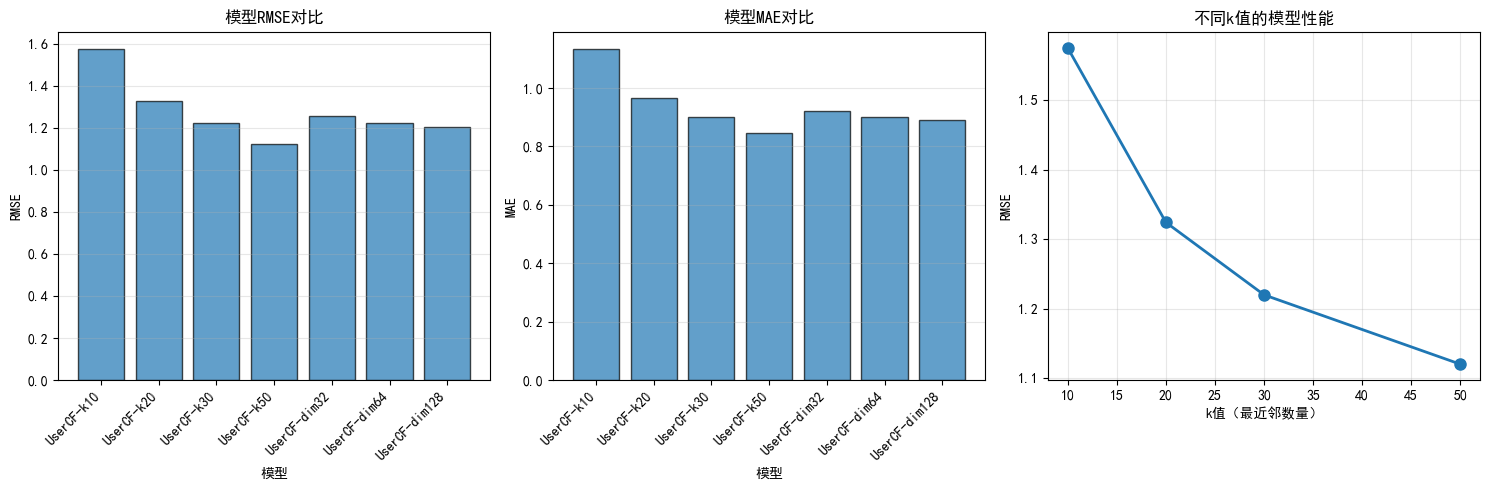


模型性能对比表:
           模型     RMSE      MAE      MSE    样本数
   UserCF-k10 1.575032 1.134234 2.480727 197526
   UserCF-k20 1.324284 0.964179 1.753728 197526
   UserCF-k30 1.220074 0.901055 1.488581 197526
   UserCF-k50 1.120361 0.845127 1.255208 197526
 UserCF-dim32 1.253067 0.920385 1.570177 197526
 UserCF-dim64 1.220079 0.901058 1.488592 197526
UserCF-dim128 1.200878 0.891842 1.442107 197526

分析推荐多样性...

推荐多样性指标:
覆盖率: 0.8241
基尼系数: 0.5771
个性化程度: 0.9951
被推荐物品数: 2815
总物品数: 3416
推荐总次数: 60400


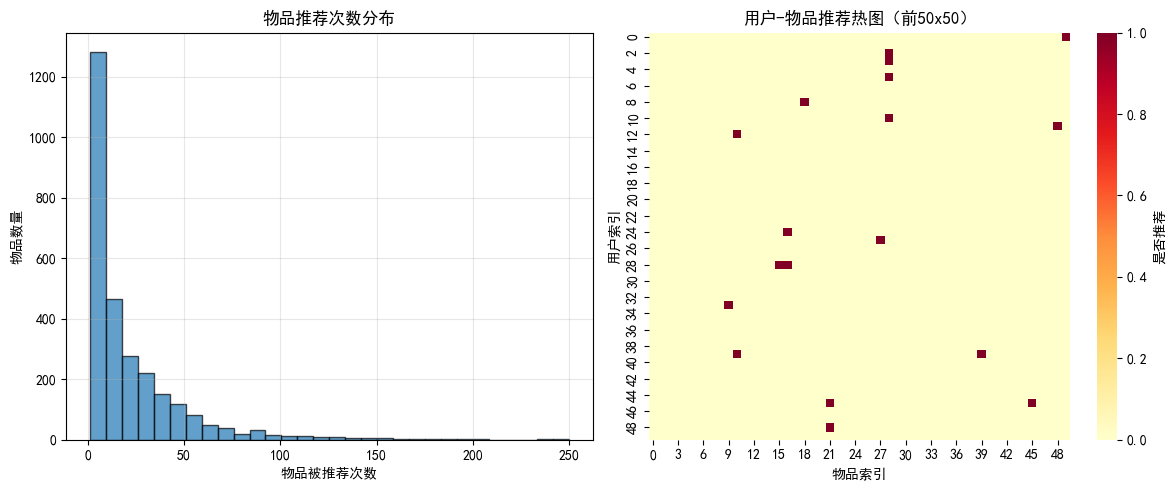


用户协同过滤总结

1. 数据统计:
   - 总用户数: 6040
   - 总物品数: 3416
   - 训练集评分数: 802085
   - 测试集评分数: 197526
   - 数据密度: 3.8875%

2. 模型性能:
   - 最佳模型: UserCF-k50
   - 最佳RMSE: 1.1204
   - 最佳MAE: 0.8451

3. 推荐质量:
   - 推荐覆盖率: 82.41%
   - 推荐个性化程度: 0.9951
   - 基尼系数: 0.5771

4. 关键参数建议:
   - 最近邻数量(k): 建议使用 50（根据RMSE最小化）
   - SVD降维维度: 建议使用64维（平衡性能和计算成本）
   - 最小用户评分数: 建议使用5（确保有足够的数据学习用户偏好）

5. 潜在改进方向:
   - 考虑时间因素：加入时间衰减权重
   - 混合推荐：结合物品协同过滤和基于内容的推荐
   - 深度学习：使用神经协同过滤（NCF）
   - 冷启动处理：为新用户使用热门物品或基于内容的推荐
   - 实时更新：增量学习新用户行为

用户协同过滤流程完成！


In [10]:
# 8.1 模型性能对比
def compare_models(models_dict, test_sparse):
    """
    比较多个模型的性能

    参数:
    - models_dict: 模型字典，格式为{'模型名称': model}
    - test_sparse: 测试集稀疏矩阵

    返回:
    - comparison_df: 对比结果的DataFrame
    """
    results = []

    for model_name, model in models_dict.items():
        print(f"\n评估 {model_name}...")
        metrics, _, _ = evaluate_model(model, test_sparse)

        results.append(
            {
                "模型": model_name,
                "RMSE": metrics["RMSE"],
                "MAE": metrics["MAE"],
                "MSE": metrics["MSE"],
                "样本数": metrics["n_samples"],
            }
        )

    comparison_df = pd.DataFrame(results)
    return comparison_df


# 8.2 训练不同参数组合的模型
print("训练不同参数组合的模型...")
models_to_compare = {}

# 不同k值
for k in [10, 20, 30, 50]:
    model_name = f"UserCF-k{k}"
    print(f"\n训练 {model_name}...")
    model = UserBasedCF(k=k, dim=64)
    model.fit(train_sparse)
    models_to_compare[model_name] = model

# 不同维度
for dim in [32, 64, 128]:
    model_name = f"UserCF-dim{dim}"
    print(f"\n训练 {model_name}...")
    model = UserBasedCF(k=30, dim=dim)
    model.fit(train_sparse)
    models_to_compare[model_name] = model

# 8.3 比较模型性能
print("\n比较模型性能...")
comparison_df = compare_models(models_to_compare, test_sparse)

# 8.4 可视化模型对比
plt.figure(figsize=(15, 5))

# RMSE对比
plt.subplot(1, 3, 1)
plt.bar(comparison_df["模型"], comparison_df["RMSE"], edgecolor="black", alpha=0.7)
plt.xlabel("模型")
plt.ylabel("RMSE")
plt.title("模型RMSE对比")
plt.xticks(rotation=45, ha="right")
plt.grid(True, alpha=0.3, axis="y")

# MAE对比
plt.subplot(1, 3, 2)
plt.bar(comparison_df["模型"], comparison_df["MAE"], edgecolor="black", alpha=0.7)
plt.xlabel("模型")
plt.ylabel("MAE")
plt.title("模型MAE对比")
plt.xticks(rotation=45, ha="right")
plt.grid(True, alpha=0.3, axis="y")

# 不同k值的性能
k_models = [m for m in comparison_df["模型"] if m.startswith("UserCF-k")]
k_values = [int(m.split("-k")[1]) for m in k_models]
k_rmse = [comparison_df.loc[comparison_df["模型"] == m, "RMSE"].values[0] for m in k_models]

plt.subplot(1, 3, 3)
plt.plot(k_values, k_rmse, marker="o", linestyle="-", linewidth=2, markersize=8)
plt.xlabel("k值（最近邻数量）")
plt.ylabel("RMSE")
plt.title("不同k值的模型性能")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 8.5 显示模型对比表格
print("\n模型性能对比表:")
print("=" * 60)
print(comparison_df.to_string(index=False))


# 8.6 推荐多样性分析
def analyze_recommendation_diversity(all_recommendations, top_n=10):
    """
    分析推荐结果的多样性

    参数:
    - all_recommendations: 所有用户的推荐结果
    - top_n: 每个用户的推荐数量

    返回:
    - diversity_metrics: 多样性指标字典
    """
    # 统计物品被推荐的总次数
    item_counts = {}
    total_recommendations = 0

    for user_id, recs in all_recommendations.items():
        for item_id, _ in recs:
            item_counts[item_id] = item_counts.get(item_id, 0) + 1
            total_recommendations += 1

    # 计算覆盖率（被推荐物品占总物品的比例）
    n_items = len(item_counts)
    total_items = max(item_counts.keys()) + 1 if item_counts else 0
    coverage = n_items / total_items if total_items > 0 else 0

    # 计算基尼系数（衡量推荐集中度）
    if item_counts:
        sorted_counts = np.sort(list(item_counts.values()))
        n = len(sorted_counts)
        cumulative_counts = np.cumsum(sorted_counts)
        cumulative_ratio = cumulative_counts / cumulative_counts[-1]

        # 基尼系数公式
        gini = 1 - 2 * np.trapz(cumulative_ratio, dx=1 / n)
    else:
        gini = 0

    # 计算平均个性化距离（用户间推荐列表的差异）
    user_rec_lists = []
    for user_id, recs in all_recommendations.items():
        if recs:
            user_rec_lists.append(set([item_id for item_id, _ in recs]))

    personalization = 0
    if len(user_rec_lists) > 1:
        similarities = []
        for i in range(len(user_rec_lists)):
            for j in range(i + 1, len(user_rec_lists)):
                # 计算Jaccard相似度
                intersection = len(user_rec_lists[i] & user_rec_lists[j])
                union = len(user_rec_lists[i] | user_rec_lists[j])
                similarity = intersection / union if union > 0 else 0
                similarities.append(similarity)

        if similarities:
            personalization = 1 - np.mean(similarities)

    diversity_metrics = {
        "覆盖率": coverage,
        "基尼系数": gini,
        "个性化程度": personalization,
        "被推荐物品数": n_items,
        "总物品数": total_items,
        "推荐总次数": total_recommendations,
    }

    return diversity_metrics


# 8.7 分析推荐多样性
print("\n分析推荐多样性...")
diversity_metrics = analyze_recommendation_diversity(all_recommendations)

print("\n推荐多样性指标:")
print("=" * 40)
for metric, value in diversity_metrics.items():
    if metric in ["覆盖率", "基尼系数", "个性化程度"]:
        print(f"{metric}: {value:.4f}")
    else:
        print(f"{metric}: {value}")

# 8.8 可视化推荐多样性
plt.figure(figsize=(12, 5))

# 物品推荐次数分布
plt.subplot(1, 2, 1)
if diversity_metrics["被推荐物品数"] > 0:
    item_counts = {}
    for user_id, recs in all_recommendations.items():
        for item_id, _ in recs:
            item_counts[item_id] = item_counts.get(item_id, 0) + 1

    counts = list(item_counts.values())
    plt.hist(counts, bins=30, edgecolor="black", alpha=0.7)
    plt.xlabel("物品被推荐次数")
    plt.ylabel("物品数量")
    plt.title("物品推荐次数分布")
    plt.grid(True, alpha=0.3)

# 推荐覆盖率热图
plt.subplot(1, 2, 2)
# 创建用户-物品推荐矩阵（前50个用户和前50个物品）
n_users_show = min(50, train_sparse.shape[0])
n_items_show = min(50, train_sparse.shape[1])

recommendation_matrix = np.zeros((n_users_show, n_items_show))
for user_id in range(n_users_show):
    if user_id in all_recommendations:
        for item_id, _ in all_recommendations[user_id]:
            if item_id < n_items_show:
                recommendation_matrix[user_id, item_id] = 1

sns.heatmap(recommendation_matrix, cmap="YlOrRd", cbar_kws={"label": "是否推荐"})
plt.xlabel("物品索引")
plt.ylabel("用户索引")
plt.title("用户-物品推荐热图（前50x50）")

plt.tight_layout()
plt.show()

# 8.9 总结与结论
print("\n" + "=" * 60)
print("用户协同过滤总结")
print("=" * 60)

print(f"\n1. 数据统计:")
print(f"   - 总用户数: {train_sparse.shape[0]}")
print(f"   - 总物品数: {train_sparse.shape[1]}")
print(f"   - 训练集评分数: {train_sparse.nnz}")
print(f"   - 测试集评分数: {test_sparse.nnz}")
print(f"   - 数据密度: {train_sparse.nnz / (train_sparse.shape[0] * train_sparse.shape[1]):.4%}")

print(f"\n2. 模型性能:")
best_model_name = comparison_df.loc[comparison_df["RMSE"].idxmin(), "模型"]
best_rmse = comparison_df["RMSE"].min()
print(f"   - 最佳模型: {best_model_name}")
print(f"   - 最佳RMSE: {best_rmse:.4f}")
print(f"   - 最佳MAE: {comparison_df.loc[comparison_df['MAE'].idxmin(), 'MAE']:.4f}")

print(f"\n3. 推荐质量:")
print(f"   - 推荐覆盖率: {diversity_metrics['覆盖率']:.2%}")
print(f"   - 推荐个性化程度: {diversity_metrics['个性化程度']:.4f}")
print(f"   - 基尼系数: {diversity_metrics['基尼系数']:.4f}")

print(f"\n4. 关键参数建议:")
print(f"   - 最近邻数量(k): 建议使用 {k_values[np.argmin(k_rmse)]}（根据RMSE最小化）")
print(f"   - SVD降维维度: 建议使用64维（平衡性能和计算成本）")
print(f"   - 最小用户评分数: 建议使用5（确保有足够的数据学习用户偏好）")

print("\n5. 潜在改进方向:")
print("   - 考虑时间因素：加入时间衰减权重")
print("   - 混合推荐：结合物品协同过滤和基于内容的推荐")
print("   - 深度学习：使用神经协同过滤（NCF）")
print("   - 冷启动处理：为新用户使用热门物品或基于内容的推荐")
print("   - 实时更新：增量学习新用户行为")

print("\n" + "=" * 60)
print("用户协同过滤流程完成！")
print("=" * 60)
